In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import time
import itertools

In [2]:
df = pd.read_csv('data/bitstamp/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv')

In [3]:
df.shape

(4727777, 8)

In [4]:
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('date', inplace=True)
df.drop('Timestamp', axis=1, inplace=True)
df = df.dropna(subset=['Close'])
df.shape

(3484305, 7)

In [5]:
df_test = df.loc['2018-01-01 00:00:00':'2020-01-11 05:00:00']
df_val = df.loc['2020-06-01':'2020-06-04']

In [6]:
df_test.shape

(1028655, 7)

In [7]:
df_val.shape

(5686, 7)

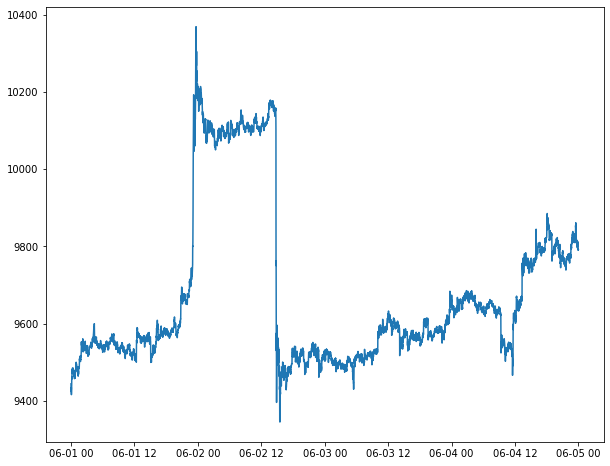

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(df_val.index, df_val['Open'])

In [9]:
def ma(X, n):
    close = X['Close']
    rolling_avg = close.rolling(window=n).mean()
    return rolling_avg

def returns(X):
    pct_change = X['Close'].pct_change()
    return pct_change

def cumulative_returns(X, lookahead=10):
    close = X['Close']
    pct_change = close.pct_change()
    rets = pct_change.rolling(window=lookahead).sum()
    return rets

def rsi(X, n=14):
    close = X['Close']
    window_length=14
    # Get the difference in price from previous step
    delta = close.diff()
    # Get rid of the first row, which is NaN since it did not have a previous 
    # row to calculate the differences
    delta = delta[1:] 

    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the EWMA
    roll_up1 = up.ewm(span=window_length).mean()
    roll_down1 = down.abs().ewm(span=window_length).mean()

    # Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(window_length).mean()
    roll_down2 = down.abs().rolling(window_length).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    # Compare graphically
    #plt.figure(figsize=(8, 6))
    #RSI1.plot()
    #RSI2.plot()
    #plt.legend(['RSI via EWMA', 'RSI via SMA'])
    #plt.show()
    
    return RSI1

def indicate_trades(df, lookahead, trading_fee):
    trades = []
    for i in range(len(df)-lookahead):
        fwd_ret = df.loc[df.index[i+lookahead], 'cumulative_returns'] 
        if abs(fwd_ret) > 2.0*trading_fee:
            if fwd_ret > 0:
                trades.append('BUY')
                #df.loc[df.index[i], 'trade'] = 'BUY'
            else:
                trades.append('SELL')
                #df.loc[df.index[i], 'trade'] = 'SELL'
        else:
            trades.append('HOLD')
            #df.loc[df.index[i], 'trade'] = 'HOLD'
    print(len(trades))
    print(df.shape)
    for i in range(lookahead):
        trades.append(np.nan)
    df['trade'] = trades
    return df

def prepare_dataset(df, ma_values, trading_fee):
    print('Calculating percentage change...')
    start = time.time()
    df['pct_change'] = returns(df)
    print('Took {}s'.format(time.time()-start))
    print('Calculating cumulative returns...')
    start = time.time()
    df['cumulative_returns'] = cumulative_returns(df, lookahead=lookahead)
    print('Took {}s'.format(time.time()-start))
    print('Calculating moving averages...')
    start = time.time()
    for ma_n in ma_values:
        df['ma_{}'.format(ma_n)] = ma(df, ma_n)
    print('Took {}s'.format(time.time()-start))
    start = time.time()
    print('Calculating RSI...')
    df['rsi'] = rsi(df)
    print('Took {}s'.format(time.time()-start))
    print('Flagging trades...')
    start = time.time()
    df = indicate_trades(df, lookahead, trading_fee)
    print('Took {}s'.format(time.time()-start))
    
    print('Computing MA indicators')
    start = time.time()
    for el in itertools.combinations(ma_values, 2):
        col_name = 'ma_{}_{}'.format(el[0], el[1])
        df[col_name] = df['ma_{}'.format(el[0])] / df['ma_{}'.format(el[1])]
    df.drop(['ma_{}'.format(i) for i in ma_values], axis=1, inplace=True)
    print('Took {}s'.format(time.time()-start))
    df = df.drop(['Open', 'High', 'Low', 'Weighted_Price', 'Volume_(BTC)', 
                  'Volume_(Currency)', 'pct_change', 'cumulative_returns'],
                       axis=1).dropna()
    df = df.dropna()
    
    print('Done...')
    return df

In [23]:
lookahead = 20
ma_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
trading_fee = 0.001

df_model = prepare_dataset(df_test, ma_values, trading_fee)

Calculating percentage change...
Took 0.018847942352294922s
Calculating cumulative returns...
Took 0.043183326721191406s
Calculating moving averages...


<ipython-input-9-4515e271abfb>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pct_change'] = returns(df)
<ipython-input-9-4515e271abfb>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_returns'] = cumulative_returns(df, lookahead=lookahead)
<ipython-input-9-4515e271abfb>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Took 0.6388144493103027s
Calculating RSI...


<ipython-input-9-4515e271abfb>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi'] = rsi(df)


Took 0.29561614990234375s
Flagging trades...
1028635
(1028655, 221)
Took 23.227856397628784s
Computing MA indicators


<ipython-input-9-4515e271abfb>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade'] = trades
<ipython-input-9-4515e271abfb>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df['ma_{}'.format(el[0])] / df['ma_{}'.format(el[1])]
c:\users\mark.breen\src\trading-bot\env\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

Took 8.841490030288696s
Done...


In [24]:
df_model_val = prepare_dataset(df_val, ma_values, trading_fee)

Calculating percentage change...
Took 0.0014889240264892578s
Calculating cumulative returns...
Took 0.001983165740966797s
Calculating moving averages...
Took 0.01686406135559082s
Calculating RSI...
Took 0.006447553634643555s
Flagging trades...
5666
(5686, 221)
Took 0.10167956352233887s
Computing MA indicators
Took 0.05724143981933594s


<ipython-input-9-4515e271abfb>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pct_change'] = returns(df)
<ipython-input-9-4515e271abfb>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_returns'] = cumulative_returns(df, lookahead=lookahead)
<ipython-input-9-4515e271abfb>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Done...


In [25]:
X = df_model.drop(['trade', 'Close'], axis=1)
X_val = df_model_val.drop(['trade', 'Close'], axis=1)
y = df_model['trade']
y_val = df_model_val['trade']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [14]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [59]:
rf.feature_importances_

array([0.01007926, 0.0084566 , 0.00763064, 0.00662381, 0.00573334,
       0.00575388, 0.00554942, 0.00533897, 0.00513326, 0.00530891,
       0.00672155, 0.00692057, 0.00795334, 0.00719489, 0.00820375,
       0.00830429, 0.00811199, 0.00798104, 0.0081668 , 0.00728776,
       0.0073013 , 0.00663824, 0.00569954, 0.00527806, 0.00481605,
       0.00450293, 0.00441981, 0.004344  , 0.00431818, 0.00486529,
       0.00479004, 0.00646311, 0.00557519, 0.00699351, 0.00630669,
       0.0060694 , 0.00617636, 0.00607774, 0.0067966 , 0.00613101,
       0.00578462, 0.00501058, 0.00470846, 0.00450989, 0.00437654,
       0.00478112, 0.00439176, 0.00428691, 0.00475946, 0.00503746,
       0.00412044, 0.00496364, 0.00578929, 0.00489889, 0.00437149,
       0.0066733 , 0.00625297, 0.00552969, 0.00514477, 0.00469635,
       0.00471783, 0.00447471, 0.00418117, 0.00397989, 0.00440271,
       0.00378214, 0.00509114, 0.00447169, 0.00419134, 0.00403326,
       0.00398513, 0.00680858, 0.00648834, 0.00551705, 0.00504

Text(0.5, 0, 'Random Forest Feature Importance')

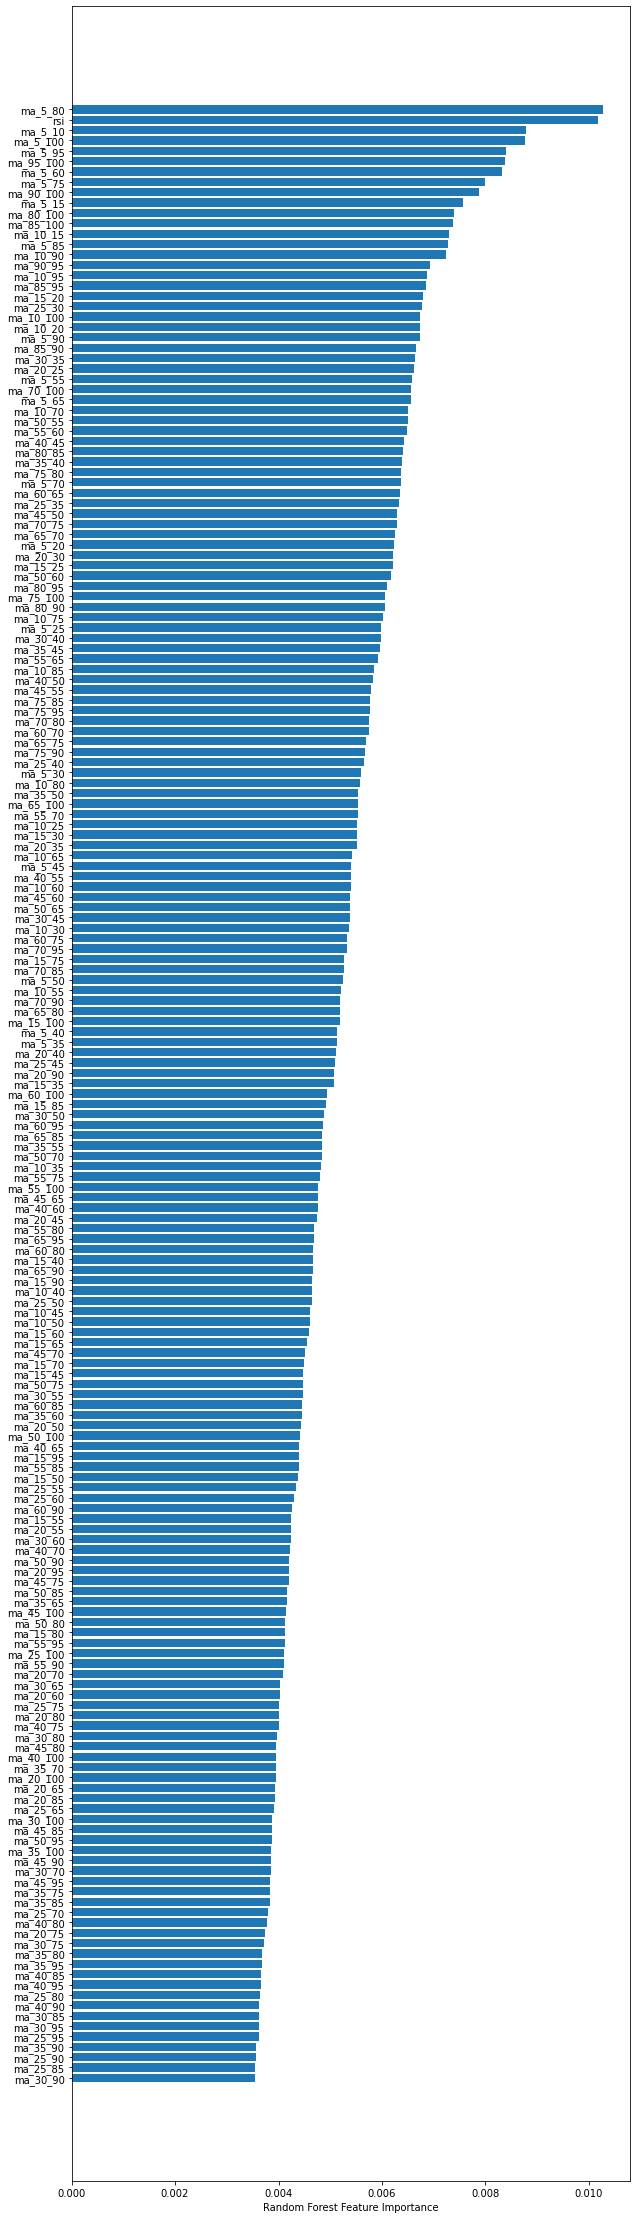

In [15]:
plt.figure(figsize=(10,40))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [16]:
f1_score(y_test, rf.predict(X_test), average='weighted')

0.7314513046888866

In [17]:
f1_score(y_val, rf.predict(X_val), average='weighted')

0.7348727349116018

In [18]:
rf.score(X_test, y_test)

0.7617155598190327

In [19]:
pred = rf.predict(X_val)

In [20]:
df_test_pred = df_model_val.copy()
df_test_pred['trade_prediction'] = pred

In [21]:
pred_buys = df_test_pred[df_test_pred['trade_prediction'] == 'BUY']
pred_sells = df_test_pred[df_test_pred['trade_prediction'] == 'SELL']
actual_buys = df_test_pred[df_test_pred['trade_prediction'] == 'BUY']
actual_sells = df_test_pred[df_test_pred['trade_prediction'] == 'SELL']

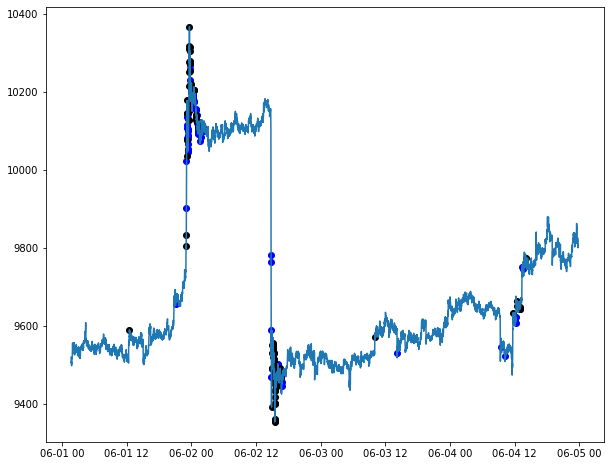

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(df_test_pred.index, df_test_pred['Close'])
plt.scatter(pred_buys.index, pred_buys['Close'], color='blue')
plt.scatter(pred_sells.index, pred_sells['Close'], color='black')
#plt.scatter(actual_buys.index, actual_buys['Close'], color='green')
#plt.scatter(actual_sells.index, actual_sells['Close'], color='red')

In [68]:
trading_fee = 0.001

In [69]:
btc_wallet = 0.0
fiat_wallet = 100.0
port_val = []

max_allocation = 0.005
max_positions = 10
open_positions = 0

for idx, row in df_test_pred.iterrows():
    if row['trade_prediction'] == 'BUY':
        if fiat_wallet > 0.0:
            btc_purchase = max_allocation*fiat_wallet/row['Close']*(1-trading_fee)
            #print('Buy {} BTC @ ${}'.format(btc_purchase, row['Close']))
            btc_wallet += btc_purchase
            fiat_wallet -= max_allocation*fiat_wallet
            #print('Bitcoin wallet: {}'.format(btc_wallet*row['Close']))
            #print('FIAT wallet: {}'.format(fiat_wallet))
    if row['trade_prediction'] == 'SELL':
        if btc_wallet > 0.0:
            btc_sell = max_allocation*btc_wallet*(1-trading_fee)
            #print('Sell {} BTC @ ${}'.format(btc_sell, row['Close']))
            btc_wallet -= btc_sell
            fiat_wallet += max_allocation*btc_wallet*row['Close']
            #print('Bitcoin wallet: {}'.format(btc_wallet*row['Close']))
            #print('FIAT wallet: {}'.format(fiat_wallet))
    port_val.append(fiat_wallet + btc_wallet*row['Close'])
        
init_btc = df_test_pred.loc[df_test_pred.index[0], 'Close']
end_btc = df_test_pred.loc[df_test_pred.index[-1], 'Close']
mkt_return = ((end_btc-init_btc)/init_btc)*100

port_return = ((port_val[-1]-port_val[0])/port_val[0])*100

print('Final Portfolio Value: {}'.format(port_val[-1]))
df_test_pred['portfolio_value'] = port_val
print('Market cumulative returns over period {}'.format(mkt_return))
print('Portfolio cumulative returns over period {}'.format(port_return))

Final Portfolio Value: 99.14326962319001
Market cumulative returns over period 3.000900322624358
Portfolio cumulative returns over period -0.8567303768099919


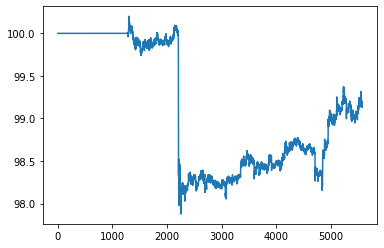

In [70]:
plt.plot(port_val)